# STABLE DIFFUSION
### `DL Course, Dr. Soleymani`
#### Homework 5
*`Full Name:`*

*`SID:`*


# Overview

In this notebook, you will dive into the fascinating world of **Stable Diffusion** and learn how to generate images using this model.

## Part 1: Introduction to Stable Diffusion and Text-to-Image Generation
- **What you'll learn:**  
  You will begin by understanding how **Stable Diffusion** works and how to use it for text-to-image generation. The model is conditioned on text prompts and can create images based on these descriptions. You will learn how to implement it step-by-step, feeding a text prompt to guide the generation of an image.

## Part 2: Exploring Attention Maps for Better Alignment
- **What you'll learn:**  
  In this part, you will explore **attention maps**, which help guide the model in generating images that better align with the provided text prompt. By visualizing attention maps, you will gain insights into how the model focuses on different parts of the input during the generation process, allowing for more precise and contextually relevant images.

## Part 3 (Bonus): Noise Optimization
- **What you'll learn:**  
  Moving beyond attention maps, you will learn about **noise optimization**. These techniques, such as applying **CLIP-score** loss, focus on optimizing the initial noise in one-step diffusion models to produce better output. You will discover how adjusting the noise in the early steps can lead to higher-quality images with better alignment to the text prompt.

---

## What is Stable Diffusion


Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) and [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). for more information.



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

## Setup & Imports

In [1]:
from argparse import Namespace
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import autocast
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, AutoProcessor, AutoModel
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, DDPMScheduler, AutoPipelineForText2Image, DiffusionPipeline, EulerAncestralDiscreteScheduler
from diffusers.models.attention_processor import Attention
import numpy as np
import os
import matplotlib.pyplot as plt
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import (
    retrieve_timesteps,
)
from typing import List, Optional, Union
from torchvision.transforms import (CenterCrop, Compose, InterpolationMode,
                                    Normalize, Resize)
import abc
from abc import ABC, abstractmethod
import math

In [2]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50           # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.Generator("cuda:0").manual_seed(42)       # Seed generator to create the inital latent noise
batch_size = 1
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# PART 1: Introduction to Stable Diffusion and Text-to-Image Generation




Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [3]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")                     # Load the autoencoder model which will be used to decode the latents into image space.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")            # The UNet model for generating the latents
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(transforms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / vae.config.scaling_factor) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

### Classifier Free Guidance

By default, the model doesn't often do what we ask. If we want it to follow the prompt better, we use a hack called CFG.

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`


In [ ]:
def prompt_to_emb(prompt):
  '''
      # TODO: This function should take in a prompt (list of strings) and return concatenated unconditional text embedding and text embeddings (torch tensor)
        1. Tokenize the prompt using the tokenizer, ensuring it fits the model's maximum length. This includes padding, truncation, and conversion to PyTorch tensors.
        2. Generate unconditional input for the model.
        3. Compute the text embedding for the provided prompt and for the unconditional input. (Disable gradients!)
        4. Concatenate the unconditional embeddings with the text embedding

  '''
  ################## TODO ##################

  ##########################################

  return text_embeddings



In [ ]:
def emb_to_latents(text_embeddings):
    '''
    This function should take in text embeddings (torch tensors) and return predicted latents.

        - Generate random latent noise for the input to the model.
        - Iterate over the scheduler timesteps.
            - Duplicate the random latent noise (to avoid doing two forward passes).
            - Scale the model input.
            - Generate noise predictions from the UNet model (disable gradients).
            - Apply classifier-free guidance scale.
            - Update the latent vectors using the scheduler step function.
    '''
    scheduler.set_timesteps(num_inference_steps)

    ################## TODO ##################

    ##########################################

  0%|          | 0/51 [00:00<?, ?it/s]

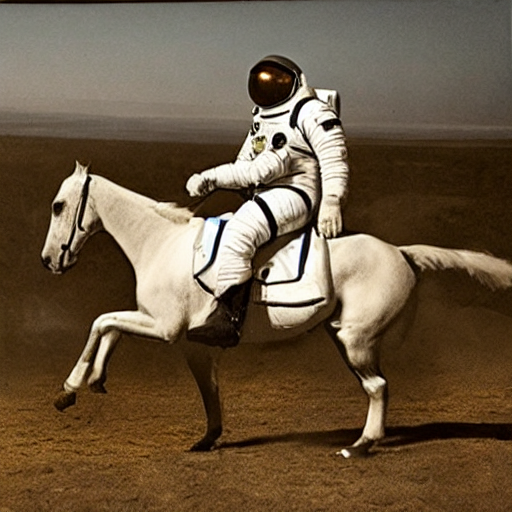

In [7]:
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

  0%|          | 0/51 [00:00<?, ?it/s]

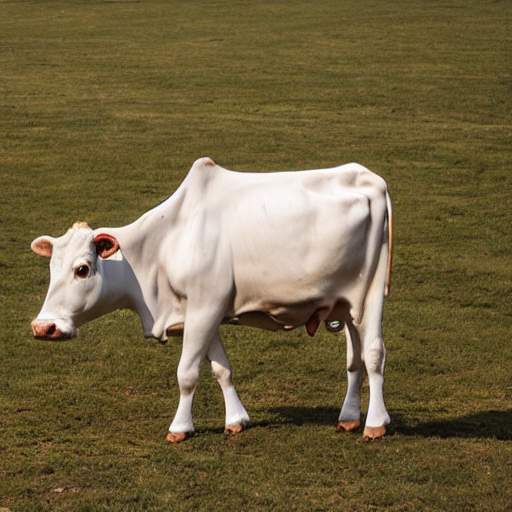

In [8]:
prompt = ["a cow and a ball"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

  0%|          | 0/51 [00:00<?, ?it/s]

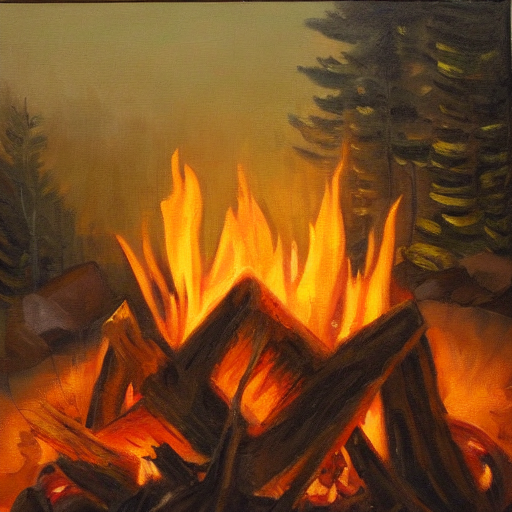

In [9]:
prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

# PART 2: Exploring Attention Maps for Better Alignment

## Additional Guidance


### 2.1. Simple Blue Loss

 How can we add some extra control to this generation process?

At each step, we're going to use our model as before to predict the noise component of x. Then we'll use this to produce a predicted output image, and apply some loss function to this image.

This function can be anything, but let's demo with a super simple example. If we want images that have a lot of blue, we can craft a loss function that gives a high loss if pixels have a low blue component:


In [ ]:
def simple_blue_loss(images):
    '''
        # TODO: this function should take in an images and return a scalar.
            - How far are the blue channel values to 0.9
    '''

    ################## TODO ##################
    
    ##########################################
    return loss

In [ ]:
simple_loss_scale = 500


def emb_to_latents_with_simple_loss(text_embeddings):
  '''
    - Use the model to predict the noise component of x.
    - Produce a predicted output image every 5 steps.
    - Compute the blue loss function and apply it to the latents.
  '''

  scheduler.set_timesteps(num_inference_steps)


  ################## TODO ##################

  
  ##########################################
  return latents

0it [00:00, ?it/s]

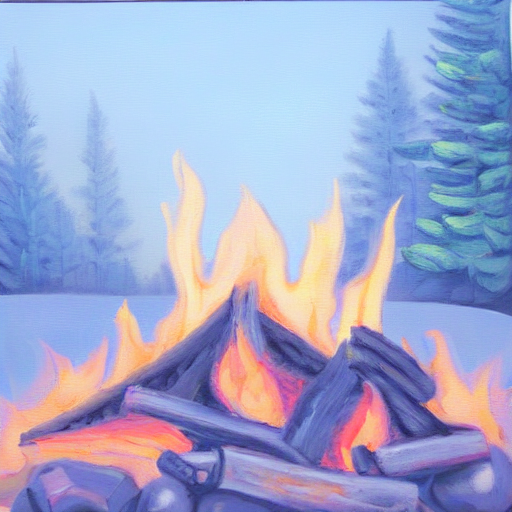

In [12]:
prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents_with_simple_loss(text_embeddings)
latents_to_pil(latents)[0]

### 2.2. Attention Maps Guidance

In generative models like Stable Diffusion, attention mechanisms play a crucial role in determining how the model focuses on different parts of the input (e.g., text or image) to generate the final output. When you're generating an image based on a text prompt, the model must decide how to map the details of the prompt onto specific visual elements within the image. However, without guidance, the model may not always place the right emphasis on the key objects or regions described in the prompt. This is where attention maps come in. By using attention map guidance, we can explicitly direct the model's focus to the regions of the image that correspond to the objects described in the prompt, ensuring that those objects are generated more accurately, clearly, and with greater detail.

#### 2.2.1. Understanding Attention in Stable Diffusion
In Stable Diffusion and other transformer-based models, attention refers to the mechanism that helps the model prioritize certain parts of the input while processing it. For instance, Text-to-image generation, When a model is given a text prompt like "a red fox running through a forest," the attention mechanism helps the model decide which parts of the input text correspond to important objects (the "red fox," the "forest") and should be focused on during the generation process.
When you want to generate an image that contains specific objects (e.g., "cat," "dog," or "mountain"), it is important to ensure that the model attends properly to those objects during the generation process. Without guidance, the model might allocate attention in ways that don’t align with your intent (e.g., focusing too much on background or irrelevant regions). A prompt like "a cat sitting on a couch" requires the model to focus on two key areas: the cat and the couch. However, when generating the image, the model may also focus on other regions, like the background or lighting, which may not be as important. So Attention maps allow us to:

- Extract where the model focuses during the generation process.
- Identify regions of the image that should receive more emphasis to enhance specific objects, like the "cat."

By analyzing the attention maps, we can pinpoint areas that are not receiving enough focus (e.g., the cat's face) and adjust the model’s focus to improve that object.



<p align="left">
<img src="https://yuval-alaluf.github.io/Attend-and-Excite/static/figures/overview.png" alt="sd-pipeline" width="500"/>
</p>

### Extracting Attention Maps

The first step involves extracting the **attention maps** from a Stable Diffusion model, such as those used in the transformer architecture that Stable Diffusion relies on.

To do this, you need to intercept the **attention layers** within the transformer model that processes the input text (in **text-to-image** generation). Below is a partial implementation for setting this up. Complete the following code to extract and store attention maps:

In [ ]:
class CrossAttnProcessor:
    """
    Custom attention processor that intercepts attention scores during forward passes in the UNet.
    """
    def __init__(self, attnstore, place_in_unet):
        super().__init__()
        self.attnstore = attnstore
        self.place_in_unet = place_in_unet

    # def __call__(self, attn: CrossAttention, hidden_states, encoder_hidden_states=None, attention_mask=None):
    def __call__(self, attn: Attention, hidden_states, encoder_hidden_states=None, attention_mask=None):
        batch_size, sequence_length, _ = hidden_states.shape
        # attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length)
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, 1)

        query = attn.to_q(hidden_states)

        is_cross = encoder_hidden_states is not None
        encoder_hidden_states = encoder_hidden_states if encoder_hidden_states is not None else hidden_states
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        self.attnstore(attention_probs, is_cross, self.place_in_unet)

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        return hidden_states

def register_attention_control(unet, controller):
    attn_procs = {}
    cross_att_count = 0
    for name in unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
            place_in_unet = "mid"
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            place_in_unet = "up"
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]
            place_in_unet = "down"
        else:
            continue

        cross_att_count += 1
        attn_procs[name] = CrossAttnProcessor(
            attnstore=controller, place_in_unet=place_in_unet
        )

    unet.set_attn_processor(attn_procs)
    controller.num_att_layers = cross_att_count

class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return 0

    @abc.abstractmethod
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            self.forward(attn, is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [], "mid_self": [], "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        self.attention_store = self.step_store
        if self.save_global_store:
            with torch.no_grad():
                if len(self.global_store) == 0:
                    self.global_store = self.step_store
                else:
                    for key in self.global_store:
                        for i in range(len(self.global_store[key])):
                            self.global_store[key][i] += self.step_store[key][i].detach()
        self.step_store = self.get_empty_store()
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = self.attention_store
        return average_attention

    def get_average_global_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.global_store[key]] for key in
                             self.attention_store}
        return average_attention

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
        self.global_store = {}

    def __init__(self, save_global_store=False):
        '''
        Initialize an empty AttentionStore
        :param step_index: used to visualize only a specific step in the diffusion process
        '''
        super(AttentionStore, self).__init__()
        self.save_global_store = save_global_store
        self.step_store = self.get_empty_store()
        self.attention_store = {}
        self.global_store = {}
        self.curr_step_index = 0

def aggregate_attention(attention_store: AttentionStore,
                        res: int,
                        from_where: List[str],
                        is_cross: bool,
                        select: int) -> torch.Tensor:
    """
    Aggregates the attention across different layers and heads at the specified resolution.

    This function extracts and aggregates attention maps from a given attention store, focusing on a specific resolution
    and filtering based on the location (e.g., "self" or "cross" attention) and layer/selection details. The attention maps
    are processed and combined to generate a single tensor that reflects the aggregated attention across different layers and heads.

    Parameters:
        - attention_store (AttentionStore): The object containing the attention maps across different layers and heads.
        - res (int): The resolution of the attention maps. Typically, this refers to the square root of the number of pixels in the attention map.
        - from_where (List[str]): List of locations indicating from where the attention maps should be aggregated.
                                The list can contain values such as 'up', 'down', or 'mid', representing different layers or regions.
                                These locations correspond to different parts of the attention map (e.g., "up" might refer to attention
                                from the top of the map, "down" from the bottom, and "mid" from the center).
        - is_cross (bool): Boolean flag indicating whether the attention is cross-attention (True) or self-attention (False).
        - select (int): The index of the attention map to select from the reshaped tensor.

    Returns:
        - torch.Tensor: A tensor representing the aggregated attention across the selected layers and heads.

    Hint:

    1. **Reshape and filter attention maps**:
        - You need to reshape the attention maps based on the `res` value. This reshaping is necessary because the original attention map may be a flat vector, and reshaping it into a grid form (e.g., `res x res`) allows you to extract specific spatial features.
        - You will filter the attention maps based on the location (using the `from_where` list). You must loop through each of the locations in `from_where`, e.g., 'up', 'down', 'mid', and apply the reshaping only if the map is of the correct shape.

    2. **Handle cross or self-attention**:
        - Use the `is_cross` flag to determine whether the attention maps refer to cross-attention or self-attention. The code already has this in the `f"{location}_{'cross' if is_cross else 'self'}"` format, which you should use when extracting the attention maps.

    3. **Aggregation**:
        - Once you have the relevant attention maps, you should aggregate them. The function already sets up a structure (`out`) to collect attention maps. Each attention map should be processed and added to this structure, and after all maps are added, the average should be computed.
        - The final result should return the average of the selected attention maps, so ensure the aggregation (e.g., sum, then average) is done correctly after concatenating all the relevant maps.
    """

    attention_maps = attention_store.get_average_attention()

    ############################# TODO #############################

    ################################################################


def display_attention_maps(attention_maps, indices_to_alter, prompt, titles = ["", ""]):
    """
    This function visualizes specific attention maps by normalizing and displaying them.

    Parameters:
    attention_maps (torch.Tensor): A tensor containing the attention maps. It is expected to have the shape (batch_size, num_heads, sequence_length).
    indices_to_alter (list of int): A list of indices indicating which attention maps to display.
    prompt (str): A textual prompt that may be used to associate with the displayed attention maps (although not currently used in the code).

    This function is useful for visualizing how specific parts of the input sequence are attended to by the model at different attention heads.

    """

    for i, index in enumerate(indices_to_alter):
        attention_map = attention_maps[:, :, index]
        normal_attention_map = (attention_map - attention_map.min())/(attention_map.max() - attention_map.min())
        normal_attention_map = normal_attention_map.detach().cpu().numpy()
        plt.imshow(Image.fromarray(np.uint8(normal_attention_map*255)).resize((512, 512)), cmap='gray')
        plt.axis('off')
        plt.title(titles[i])
        plt.show()

In [14]:
attention_store = AttentionStore()
register_attention_control(unet, attention_store)
attention_res = 16

  0%|          | 0/51 [00:00<?, ?it/s]

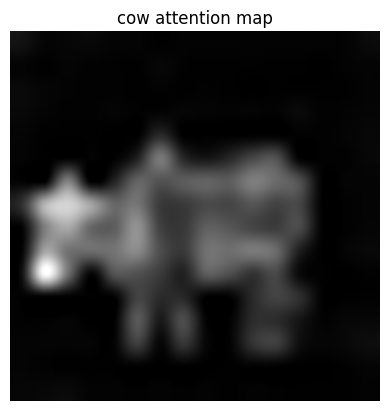

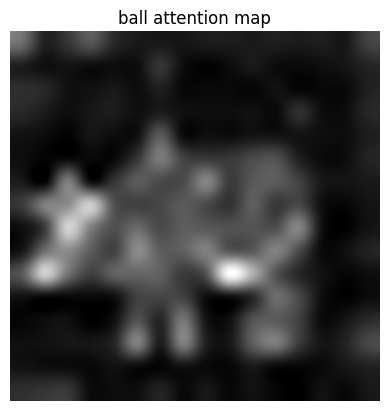

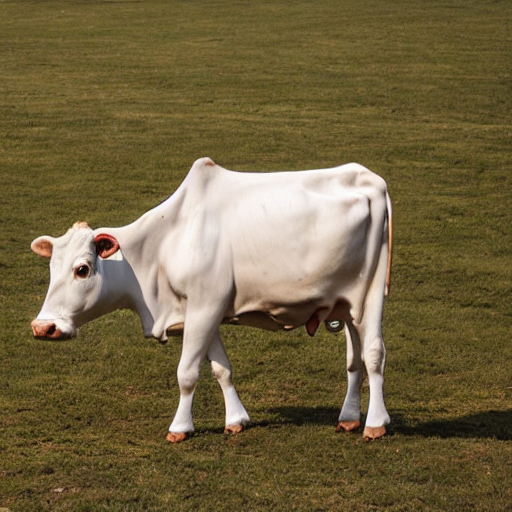

In [15]:
# Visualize Attention Maps for a simple example.
prompt = ["a cow and a ball"]
text_embeddings = prompt_to_emb(prompt)
indices_to_alter = [2, 5] # 0: <sot>, a: 1, cow: 2, and: 3, a: 4, ball: 5 ,.... So we select 2 and 5.
latents = emb_to_latents(text_embeddings=text_embeddings)
attention_maps = aggregate_attention(attention_store=attention_store,
                                     res=attention_res,
                                     from_where=("up", "down", "mid"),
                                     is_cross=True,
                                     select=0)

display_attention_maps(attention_maps, indices_to_alter, prompt, ['cow attention map', 'ball attention map'])
image = latents_to_pil(latents)
image[0]

  0%|          | 0/51 [00:00<?, ?it/s]

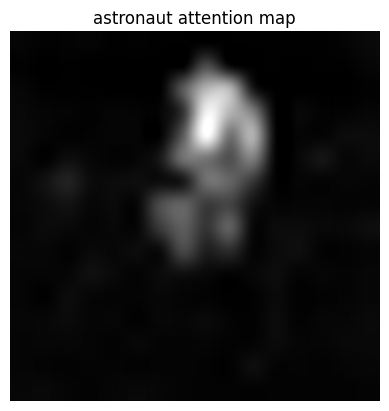

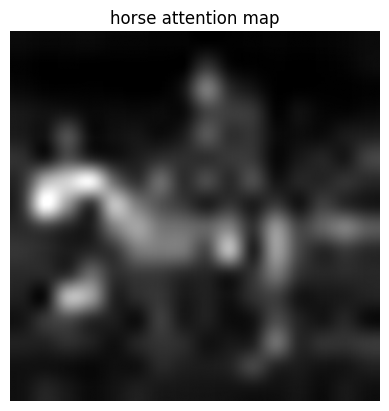

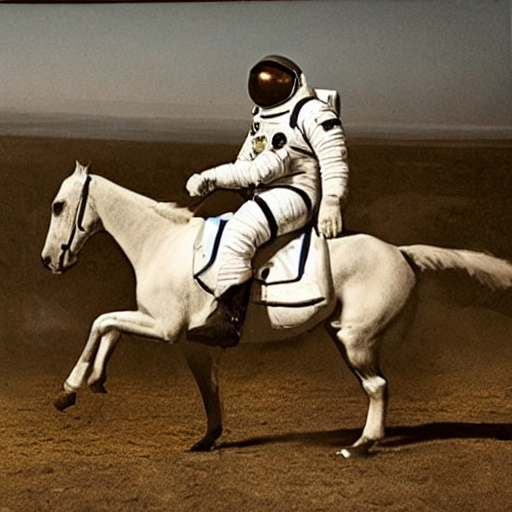

In [16]:
# Visualize Attention Maps for a simple example.
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
indices_to_alter = [5, 8] # astronaut: 5, horse: 8
latents = emb_to_latents(text_embeddings=text_embeddings)
attention_maps = aggregate_attention(attention_store=attention_store,
                                     res=attention_res,
                                     from_where=("up", "down", "mid"),
                                     is_cross=True,
                                     select=0)

display_attention_maps(attention_maps, indices_to_alter, prompt, ['astronaut attention map', 'horse attention map'])
image = latents_to_pil(latents)
image[0]

In [17]:
torch.cuda.empty_cache()


Once you have the attention maps, the next step is to create loss functions that guide the model to focus on specific regions of the image (e.g., improving the generation of certain objects, features, or areas). The following loss functions are commonly used to achieve this:


## Attend and Excite Loss

The **Attend and Excite** method aims to ensure that each important token in the input prompt is **attended to** during image generation. This is particularly useful when certain words (e.g., object names) tend to be ignored or underrepresented in the final image.

### Definition:
Attend and Excite introduces a **loss** that increases the attention on underrepresented tokens by monitoring the attention maps. Specifically, it finds the **maximum attention value** for each target token across spatial dimensions and **maximizes** this value.


**Attend and Excite Loss** is defined as:

$ L_s = 1 - \max(A_t^s) $

$\mathcal{L}_{\text{A\&E}} = \max_{s \in S} (L_s)$


Where:
- S is the set of important tokens (e.g., nouns or object descriptors),
- $ A_t^s \text{ is the attention } \text{ for token } s $


This loss penalizes low attention on key tokens, effectively “exciting” the model to generate content related to them.

---

## Token Overlap and Object Missing

In some cases, **multiple tokens may refer to spatially overlapping regions** in the image. When this happens, the attention for one token can suppress the attention of another, especially if their semantic meanings are close or the tokens are visually ambiguous. This may cause **object missing** or degraded visual quality in the generated image.

### Example:
If the prompt is `"a cat and a dog on a couch"`, the attention for "cat" and "dog" might overlap, especially if the model associates both with similar textures (fur, shape, etc.). This overlap can cause the model to focus more on one and neglect the other.

For example:


<p align="left">
<img src="https://i.postimg.cc/Ws3xR0rw/iou.png" alt="sd-pipeline" width="500" style="top: -1000px; left: -100px"/>
</p>

You can see that in the first image, there is no overlap; both objects appear. However, in the second image, the `cat` is missing.


### IOU Loss

The **Intersection over Union (IOU)** loss is used to measure how much overlap exists between the attention maps of two tokens. This loss encourages the model to minimize unnecessary overlap while ensuring that each token gets a distinct region of focus.

### Definition:

Given two attention maps, $ A_{t_i} $ and $ A_{t_j} $ , the **IOU** loss is computed as the ratio of the intersection and the union of the attention maps for token pairs $ t_i $ and $ t_j $. The formula is as follows:

$
\mathcal{L}_{\text{IOU}} = \frac{\sum_{x \in I} A_{t_i}(x) \cdot A_{t_j}(x)}{\sum_{x \in U} A_{t_i}(x) + A_{t_j}(x)}
$

Where:
- I represents the intersection of the attention maps (where both tokens are attended),
- U represents the union of the attention maps (all areas attended by either token),
- $ A_{t_i}(x) $ is the attention value for token $ t_i $ at location x,
- The numerator is the intersection of attention maps, while the denominator represents the union.

This loss penalizes the model for overlapping attention areas and encourages the model to give distinct focus to each token, reducing the risk of object omissions due to attention conflicts.


### Center of Mass (COM) Loss:

The center of mass for a given attention map can be computed by considering the weighted average position based on the attention values. For a given attention map
$ A_t $ (where each pixel has an attention value), the center of mass
$ COM(A_t) $ is computed as:

$ \text{COM}(A_t) = \left( \frac{\sum_{x} x \cdot A_t(x)}{\sum_{x} A_t(x)}, \frac{\sum_{y} y \cdot A_t(y)}{\sum_{y} A_t(y)} \right) $

Where:
- $ A_t(x) $ is the attention value at position $ x $,
- $ x $ and $ y $ represent spatial coordinates (rows and columns of the attention map),
- The sums are performed over all pixels in the attention map.

Once we compute the center of mass for each attention map, we want to **increase the distance between the COMs** of each attention map to encourage more focused attention on distinct regions. The **center of mass distance loss** $ L_{\text{COM}} $ for two attention maps $ A_t^i $ and $ A_t^j $ can be defined as:

$
L_{\text{COM}}(A_t^i, A_t^j) = D_{\text{COM}}(A_t^i, A_t^j)
$

Where:
- $ D_{\text{COM}}(A_t^i, A_t^j) $ is the Euclidean distance between the centers of mass of $ A_t^i $ and $ A_t^j $:

  $
  D_{\text{COM}}(A_t^i, A_t^j) = \sqrt{\left( \text{COM}_x(A_t^i) - \text{COM}_x(A_t^j) \right)^2 + \left( \text{COM}_y(A_t^i) - \text{COM}_y(A_t^j) \right)^2}
  $

- $ \text{threshold} $ is a minimum distance below which the loss will be applied, encouraging the separation of COMs.



---

These training-free loss functions can be applied during inference or as part of an optimization loop that adjusts the latent or conditioning input without modifying the diffusion model weights.

Now we want to implement the update to the latent by attention map losses. You can define different losses (like center-of-mass loss, KL loss, IOU loss, and attend & excite loss).

**Note**: The choice of losses is up to you, and you can define any loss function you deem necessary. The goal is to achieve the best results, and the score for this section will be based on your output.

In [ ]:


def cross_attention_compute_loss(attention_maps,
                                 indices_to_alter,
                                 i) -> torch.Tensor:

    """
    Computes a loss based on the attention maps at specified indices.

    Args:
        - attention_maps (torch.Tensor): representing the attention maps
        - indices_to_alter (tuple or list of two integers): The indices of tokens to compute the loss
        - i (int): Iteration number. This parameter may be used or not, depending on the implementation.

    Returns:
        torch.Tensor: A scalar tensor representing the loss.
    """
    ################################################# TODO ##########################################################
    
    
    ################################################################################################################

@staticmethod
def _update_latent(latents: torch.Tensor, loss: torch.Tensor, step_size: float) -> torch.Tensor:
    """
    Updates the latent tensor according to the computed loss using gradient descent.

    Args:
        latents (torch.Tensor): The tensor representing the current latent variables of the model.
                               Shape: (batch_size, latent_dim).
        loss (torch.Tensor): A scalar tensor representing the computed loss.
        step_size (float): The step size (learning rate) for updating the latents.

    Returns:
        torch.Tensor: The updated latent tensor after applying the gradient descent update.
                      It will have the same shape as the input latents.
    """

    ############################### TODO ###############################
    
    
    ####################################################################


def emb_to_latents_with_attentions_maps_loss(attention_store, indices_to_alter, attention_res, text_embeddings, max_iter_to_alter=25):

        """
        This function generates and updates latents based on the attention maps and computes a loss to
        reduce overlap between indices to alter. The loss can be modified to use different types such as
        KL divergence, COM loss, or Attend and Excite loss (Read their paper if needed to apply this loss).

        Args:
            - attention_store (list or Tensor): The stored attention maps from the model.
            - indices_to_alter (list or Tensor): The indices or positions in the attention maps to focus on and alter.
            - attention_res (tuple): The resolution of the attention maps, used to aggregate attention.
            - text_embeddings (Tensor): The text embeddings used as input to the model.
            - max_iter_to_alter (int, optional): The maximum number of iterations to focus on altering the specified indices. Default is 25.

        Returns:
            - Tensor: The updated latents after iterating through the scheduler steps.

        **Hints:**
            1. This function is similar to `emb_to_latents`, but the key difference is that you should update the
                latent based on your defined loss on the attention maps of indices to alter. Perform this update
                only in the first `max_iter_to_alter` iterations.
            2. Don't forget to enable gradients for the latents, as you need to update them based on the loss.
            3. You should pass only the conditional part of the text embeddings to the model. Then, extract its attention
                map and perform the update on the latents based on the computed loss.
        """

        ############################### TODO ###############################


        ####################################################################

        
        

0it [00:00, ?it/s]

--------------------------------------------------
Iteration 0 | Loss: -0.2039
--------------------------------------------------
Iteration 1 | Loss: -0.2800
--------------------------------------------------
Iteration 2 | Loss: -0.2759
--------------------------------------------------
Iteration 3 | Loss: -0.3245
--------------------------------------------------
Iteration 4 | Loss: -0.3519
--------------------------------------------------
Iteration 5 | Loss: -0.3748
--------------------------------------------------
Iteration 6 | Loss: -0.3898
--------------------------------------------------
Iteration 7 | Loss: -0.3997
--------------------------------------------------
Iteration 8 | Loss: -0.4055
--------------------------------------------------
Iteration 9 | Loss: -0.4194
--------------------------------------------------
Iteration 10 | Loss: -0.4274
--------------------------------------------------
Iteration 11 | Loss: -0.4497
--------------------------------------------------

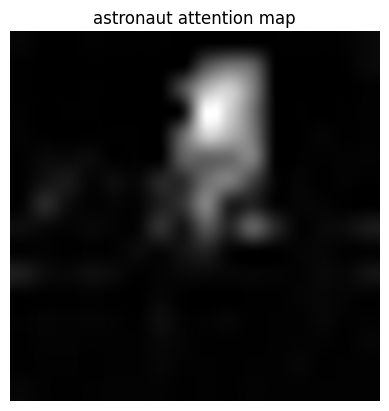

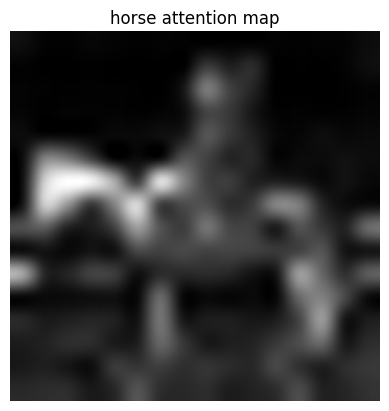

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
indices_to_alter = [5, 8]
latents = emb_to_latents_with_attentions_maps_loss(attention_store=attention_store,
                                                   indices_to_alter=indices_to_alter,
                                                   attention_res=attention_res,
                                                   text_embeddings=text_embeddings)
attention_maps = aggregate_attention(attention_store=attention_store,
                                     res=attention_res,
                                     from_where=("up", "down", "mid"),
                                     is_cross=True,
                                     select=0)

display_attention_maps(attention_maps, indices_to_alter, prompt, ['astronaut attention map', 'horse attention map'])
image = latents_to_pil(latents)
image[0]

del latents
del attention_maps
del image

--------------------------------------------------
Iteration 2 | Loss: -0.1406
--------------------------------------------------
Iteration 3 | Loss: -0.1701
--------------------------------------------------
Iteration 4 | Loss: -0.2078
--------------------------------------------------
Iteration 5 | Loss: -0.2378
--------------------------------------------------
Iteration 6 | Loss: -0.2740
--------------------------------------------------
Iteration 7 | Loss: -0.3254
--------------------------------------------------
Iteration 8 | Loss: -0.3438
--------------------------------------------------
Iteration 9 | Loss: -0.3404
--------------------------------------------------
Iteration 10 | Loss: -0.4725
--------------------------------------------------
Iteration 11 | Loss: -0.4810
--------------------------------------------------
Iteration 12 | Loss: -0.5292
--------------------------------------------------
Iteration 13 | Loss: -0.5673
------------------------------------------------

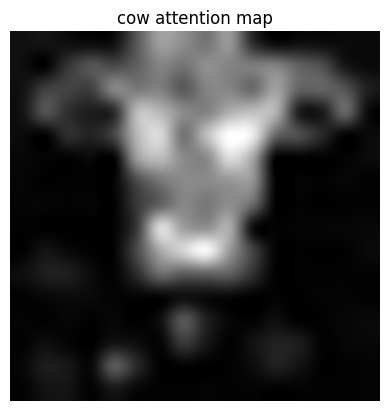

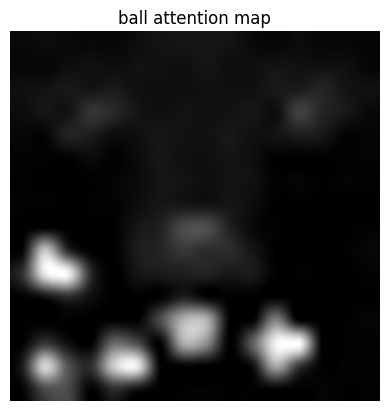

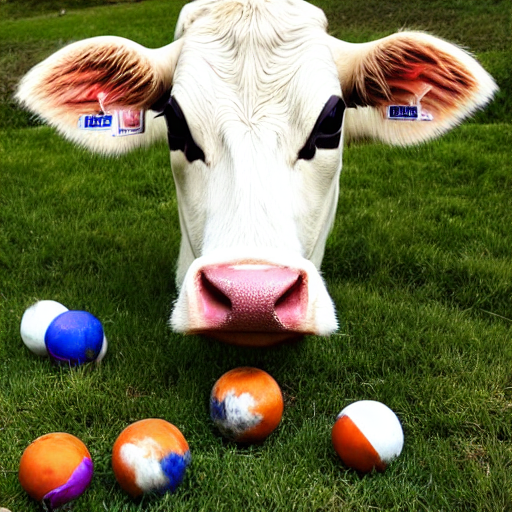

In [22]:
prompt = ["a cow and a ball"]
text_embeddings = prompt_to_emb(prompt)
indices_to_alter = [2, 5]
latents = emb_to_latents_with_attentions_maps_loss(attention_store=attention_store,
                                                   indices_to_alter=indices_to_alter,
                                                   attention_res=attention_res,
                                                   text_embeddings=text_embeddings,)
attention_maps = aggregate_attention(attention_store=attention_store,
                                     res=attention_res,
                                     from_where=("up", "down", "mid"),
                                     is_cross=True,
                                     select=0)

display_attention_maps(attention_maps, indices_to_alter, prompt, ['cow attention map', 'ball attention map'])
image = latents_to_pil(latents)
image[0]

del latents
del attention_maps
del image

In [24]:
del vae
del tokenizer
del text_encoder
del unet
del scheduler
del attention_store

torch.cuda.empty_cache()

# Part 3 (Bonus): Noise Optimization

In generative models like Stable Diffusion, the quality of the generated image can be significantly affected by the level of noise introduced during the generation process. Noise optimization is a technique aimed at reducing this noise and improving the visual quality of the output. One key way to assess and optimize this noise is by using metrics that measure how closely the generated image matches the desired outcome.

To enhance the efficiency of the noise optimization process, SDXL-Turbo is selected for generating the output in a single timestep. SDXL-Turbo is an advanced variant of the Stable Diffusion model designed to speed up the image generation process without sacrificing quality.

By using SDXL-Turbo, we can reduce the computational cost of running the model while still generating high-quality outputs. The single-timestep generation is particularly beneficial because it ensures the image is produced in one step, eliminating the need for multiple iterations that might introduce additional noise or inconsistencies.

The Process of Noise Optimization with SDXL-Turbo:

1. Initialization: Start with a randomly generated noisy image.

2. Diffusion Process: Apply the diffusion process to the noisy latent and generate the image.

3. Metrics Evaluation: After generating the image, evaluate it using various metrics to optimize the initial latent noise for the best results.

4. Optimization: Adjust the noise levels at each step to optimize the metrics, improving the relevance and quality of the image.

5. Final Output: Once the noise optimization is complete, the output image is generated in one timestep using SDXL-Turbo, ensuring both efficiency and high-quality results.

6. Repeat the Process: The process is repeated multiple times to achieve the best possible results.

You can use various metrics to achieve the best results. The models used should be vision-language models (VLM) capable of comparing the similarity between text and image. The choice of model is up to you. However, we recommend using CLIP-score and PickScoreLoss for optimal results.




<p align="left">
<img src="https://www.eml-munich.de/publications/ReNO/teaser.png" alt="sd-pipeline" width="500"/>
</p>


In [27]:
model_id = "stabilityai/sd-turbo"
model = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to('cuda')
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to('cuda')
model.scheduler = EulerAncestralDiscreteScheduler.from_config(model.scheduler.config, timestep_spacing="trailing")

model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
# Freeze the parameters of specific model components to prevent them from being updated during training
# This is typically done to reduce computational cost and focus on training specific parts of the model.
# Freeze the parameters for the VAE, UNet, and text encoders
# Enable gradient checkpointing for both UNet and VAE to save memory during the backward pass
# Don't forget that model has two text encoder. (`text_encoder` and `text_encoder_2`)


############################## TODO ##############################


##################################################################

In [29]:
# Don't change this cell.

def decode_latents_tensors(model, latents):
        latents = latents / model.vae.config.scaling_factor
        print(latents.dtype)
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        return image

def apply(
        model,
        latents: torch.Tensor,
        prompt: Union[str, List[str]],
        num_inference_steps: int = 1,
        guidance_scale: float = 0.0,
        timesteps: List[int] = None,
        denoising_end: Optional[float] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
    ) -> torch.Tensor:


        do_classifier_free_guidance: bool = False

        # 0. Default height and width to unet
        height = model.default_sample_size * model.vae_scale_factor
        width = model.default_sample_size * model.vae_scale_factor

        original_size = (height, width)
        target_size = (height, width)

        model._guidance_scale = guidance_scale
        model._cross_attention_kwargs = None
        model._denoising_end = denoising_end
        model._interrupt = False

        batch_size = 1
        device = model._execution_device

        # 3. Encode input prompt
        prompt_embeds = None
        negative_prompt_embeds = None
        pooled_prompt_embeds = None
        negative_pooled_prompt_embeds = None
        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = model.encode_prompt(
            prompt=prompt,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=True
        )

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            model.scheduler, num_inference_steps, device, timesteps
        )

        num_channels_latents = model.unet.config.in_channels
        latents = model.prepare_latents(
            1,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = model.prepare_extra_step_kwargs(generator, eta)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        if model.text_encoder_2 is None:
            text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
        else:
            text_encoder_projection_dim = model.text_encoder_2.config.projection_dim

        add_time_ids = model._get_add_time_ids(
            original_size,
            (0, 0),
            target_size,
            dtype=prompt_embeds.dtype,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )
        negative_add_time_ids = add_time_ids

        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat(
                [negative_pooled_prompt_embeds, add_text_embeds], dim=0
            )
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(
            batch_size * num_images_per_prompt, 1
        )

        # 8. Denoising loop
        num_warmup_steps = max(
            len(timesteps) - num_inference_steps * model.scheduler.order, 0
        )

        # 8.1 Apply denoising_end
        if (
            model.denoising_end is not None
            and isinstance(model.denoising_end, float)
            and model.denoising_end > 0
            and model.denoising_end < 1
        ):
            discrete_timestep_cutoff = int(
                round(
                    model.scheduler.config.num_train_timesteps
                    - (model.denoising_end * model.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(
                list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps))
            )
            timesteps = timesteps[:num_inference_steps]

        # 9. Optionally get Guidance Scale Embedding
        timestep_cond = None
        if model.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(model.guidance_scale - 1).repeat(
                batch_size * num_images_per_prompt
            )
            timestep_cond = model.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=model.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        model._num_timesteps = len(timesteps)

        # 8. Denoising loop
        # 8.1 Apply denoising_end
        if (
            model.denoising_end is not None
            and isinstance(model.denoising_end, float)
            and model.denoising_end > 0
            and model.denoising_end < 1
        ):
            discrete_timestep_cutoff = int(
                round(
                    model.scheduler.config.num_train_timesteps
                    - (model.denoising_end * model.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(
                list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps))
            )
            timesteps = timesteps[:num_inference_steps]

        # 9. Optionally get Guidance Scale Embedding
        timestep_cond = None

        model._num_timesteps = len(timesteps)

        for i, t in enumerate(timesteps):
            if model._interrupt:
                continue
            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                torch.cat([latents] * 2)
                if do_classifier_free_guidance
                else latents
            )

            latent_model_input = model.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            added_cond_kwargs = {
                "text_embeds": add_text_embeds,
                "time_ids": add_time_ids,
            }
            noise_pred = model.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                cross_attention_kwargs=model.cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]

            # perform guidance

            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + model.guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            # compute the previous noisy sample x_t -> x_t-1
            latents = model.scheduler.step(
                noise_pred, t, latents, **extra_step_kwargs, return_dict=False
            )[0]


        image = decode_latents_tensors(model, latents)

        model.maybe_free_model_hooks()

        return image

In [30]:
class BaseRewardLoss(ABC):
    """
    Base class for reward functions implementing a differentiable reward function for optimization.
    In this base class, subclasses should implement the methods to extract features from both images and text,
    and compute the loss between these features. The child classes should also implement the functions
    to find and compute their specific metric scores.
    """

    def __init__(self, name: str, weighting: float):
        self.name = name
        self.weighting = weighting

    @staticmethod
    def freeze_parameters(params: torch.nn.ParameterList):
        for param in params:
            param.requires_grad = False

    @abstractmethod
    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        pass

    @abstractmethod
    def get_text_features(self, prompt: str) -> torch.Tensor:
        pass

    @abstractmethod
    def compute_loss(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        pass

    def process_features(self, features: torch.Tensor) -> torch.Tensor:
        features_normed = features / features.norm(dim=-1, keepdim=True)
        return features_normed

    def __call__(self, image: torch.Tensor, prompt: str) -> torch.Tensor:
        image_features = self.get_image_features(image)
        text_features = self.get_text_features(prompt)

        image_features_normed = self.process_features(image_features)
        text_features_normed = self.process_features(text_features)

        loss = self.compute_loss(image_features_normed, text_features_normed)
        return loss

########################### TODO ################################

"""
This section is where you should add your specific metric calculation functions.
You need to implement the functions to compute the metric score for your chosen reward function.
For example, you can calculate the score using a similarity measure, or any other relevant metric.
Ensure that these metrics are related to your loss function's purpose, and contribute meaningfully to the optimization process.
"""


############################################################

In [46]:
n_iters = 100
device = torch.device("cuda")

size = 224
preprocess_fn = Compose([Resize(size, interpolation=InterpolationMode.BICUBIC),
                         CenterCrop(size),
                         Normalize(
                            (0.48145466, 0.4578275, 0.40821073),
                            (0.26862954, 0.26130258, 0.27577711),
                        )])

regularization_weight = 0.01

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [49]:
def train_latent(model, optimizer, reward_losses, prompt, latents, generator):

    """
    In this section, you will define the training loop where the latent vector
    optimization process takes place. The goal of this optimization is to adjust
    the latent representation in such a way that it minimizes the metrics or loss function.


    Inputs:
    - model: The sdxl-turbo model.
    - optimizer (torch.optim.Optimizer): The optimizer used to update the latent vectors during optimizing the latents.
    - reward_losses (list of reward functions): A list of reward functions that compute the loss or metric between the generated image and the expected output based on the prompt.
    - prompt (str): A textual prompt or description that guides the generation process. The model generates an image that should match the description provided in the prompt.
    - latents (torch.Tensor): A tensor of shape `(batch_size, latent_dim)` representing the initial latent space values from which the image is generated. These latents are optimized during the training process to improve the generated image.
    - generator (torch.Generator): A random number generator used for reproducibility in the model's random processes (e.g., noise generation) during the training process.

    Expected Output:
    - initial_image (PIL.Image): The first image generated at the beginning of the training loop, before any optimization takes place. This is saved and can be used as a reference to compare the improvement during training.
    - best_image_pil (PIL.Image): The best image generated throughout the training loop, where the total reward loss is minimized. This image corresponds to the optimized latent vector that produces the best result for the prompt.
    - initial_rewards (dict): A dictionary containing the initial reward values (losses) associated with the first image generated. This can be used to assess how well the initial latent vector performed before optimization.
    - best_rewards (dict): A dictionary containing the reward values (losses) associated with the best image generated during training. This helps assess how much the optimization improved the results compared to the initial image.

    Steps:
    - Generate the image based on the latents.
    - Evaluate the generated image using the reward functions.
    - Update the latents using the optimizer to minimize the reward loss.
    - Repeat the process for `n_iters` iterations to optimize the latent space.
    - When computing the loss, don't forget to add the regularization loss term for the latent.
    """

    best_loss = torch.inf
    best_image = None
    initial_image = None
    initial_rewards = None
    best_rewards = None
    best_latents = None
    latent_dim = math.prod(latents.shape[1:])

    ###################################### TODO ######################################

    
    ##################################################################################

    return initial_image, best_image_pil, initial_rewards, best_rewards

  0%|          | 0/100 [00:00<?, ?it/s]

torch.float16
total_reward_loss: 1.015625
best_loss: inf
torch.float16
total_reward_loss: 1.041015625
best_loss: 1.015625
torch.float16
total_reward_loss: 1.0048828125
best_loss: 1.015625
torch.float16
total_reward_loss: 0.97265625
best_loss: 1.0048828125
torch.float16
total_reward_loss: 0.978515625
best_loss: 0.97265625
torch.float16
total_reward_loss: 0.986328125
best_loss: 0.97265625
torch.float16
total_reward_loss: 0.9833984375
best_loss: 0.97265625
torch.float16
total_reward_loss: 0.94384765625
best_loss: 0.97265625
torch.float16
total_reward_loss: 0.9453125
best_loss: 0.94384765625
torch.float16
total_reward_loss: 0.947265625
best_loss: 0.94384765625
torch.float16
total_reward_loss: 0.962890625
best_loss: 0.94384765625
torch.float16
total_reward_loss: 0.94970703125
best_loss: 0.94384765625
torch.float16
total_reward_loss: 0.951171875
best_loss: 0.94384765625
torch.float16
total_reward_loss: 0.95654296875
best_loss: 0.94384765625
torch.float16
total_reward_loss: 0.9609375
best_los

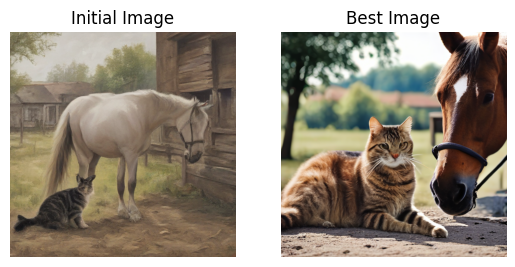

  0%|          | 0/100 [00:00<?, ?it/s]

torch.float16


In [47]:
generator = torch.Generator("cuda").manual_seed(42)
height = model.default_sample_size * model.vae_scale_factor
width = model.default_sample_size * model.vae_scale_factor
prompt = "a cat and a horse"
shape = (
    1,
    model.unet.config.in_channels,
    height // model.vae_scale_factor,
    width // model.vae_scale_factor,
)
init_latents = torch.randn(shape, device=device, dtype=torch.float16, generator=generator)

###################################### TODO ######################################
# 1. Create a trainable `torch.nn.Parameter` from the `init_latents` tensor, which will allow the latent vectors to be updated during training.
# 2. Set up an optimizer (e.g., SGD, Adam, etc.) to optimize the latents.


##################################################################################

initial_image, best_image_pil, initial_rewards, best_rewards = train_latent(model, optimizer, reward_losses, prompt, latents, generator)
print(initial_rewards)
print(best_rewards)
plt.subplot(1, 2, 1)
plt.imshow(initial_image)
plt.axis('off')
plt.title("Initial Image")

plt.subplot(1, 2, 2)
plt.imshow(best_image_pil)
plt.axis('off')
plt.title("Best Image")

plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

torch.float16
total_reward_loss: 0.9677734375
best_loss: inf
torch.float16
total_reward_loss: 0.94384765625
best_loss: 0.9677734375
torch.float16
total_reward_loss: 0.935546875
best_loss: 0.94384765625
torch.float16
total_reward_loss: 0.939453125
best_loss: 0.935546875
torch.float16
total_reward_loss: 0.9267578125
best_loss: 0.935546875
torch.float16
total_reward_loss: 0.9267578125
best_loss: 0.9267578125
torch.float16
total_reward_loss: 0.92529296875
best_loss: 0.9267578125
torch.float16
total_reward_loss: 0.9326171875
best_loss: 0.92529296875
torch.float16
total_reward_loss: 0.92578125
best_loss: 0.92529296875
torch.float16
total_reward_loss: 0.923828125
best_loss: 0.92529296875
torch.float16
total_reward_loss: 0.92333984375
best_loss: 0.923828125
torch.float16
total_reward_loss: 0.916015625
best_loss: 0.92333984375
torch.float16
total_reward_loss: 0.90625
best_loss: 0.916015625
torch.float16
total_reward_loss: 0.904296875
best_loss: 0.90625
torch.float16
total_reward_loss: 0.9052734

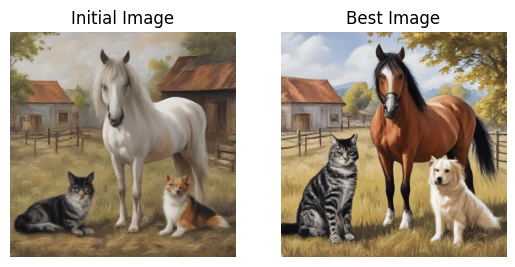

In [45]:
generator = torch.Generator("cuda").manual_seed(42)
height = model.default_sample_size * model.vae_scale_factor
width = model.default_sample_size * model.vae_scale_factor
prompt = "a cat and a horse and a dog"
shape = (
    1,
    model.unet.config.in_channels,
    height // model.vae_scale_factor,
    width // model.vae_scale_factor,
)
init_latents = torch.randn(shape, device=device, dtype=torch.float16, generator=generator)

###################################### TODO ######################################
# 1. Create a trainable `torch.nn.Parameter` from the `init_latents` tensor, which will allow the latent vectors to be updated during training.
# 2. Set up an optimizer (e.g., SGD, Adam, etc.) to optimize the latents.


##################################################################################

initial_image, best_image_pil, initial_rewards, best_rewards = train_latent(model, optimizer, reward_losses, prompt, latents, generator)
print(initial_rewards)
print(best_rewards)

plt.subplot(1, 2, 1)
plt.imshow(initial_image)
plt.axis('off')
plt.title("Initial Image")

plt.subplot(1, 2, 2)
plt.imshow(best_image_pil)
plt.axis('off')
plt.title("Best Image")

plt.show()


Now after noise optimization, your task is to randomly choose 10 seeds and perform seed selection and noise optimization on them based on the rewards they get and plot the results of the best seed.

In [ ]:
############################## TODO ##############################

##################################################################